# Regression: Housing prices

Methods covered in this notebook:
* Linear regression
* Outlier removal
* Scaling input features
* Dimensionality reduction with PCA
* Pipelines
* Cross validation with GridSearchCV

In [211]:
# import packages

import numpy as np, pandas as pd, seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import cm

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, minmax_scale, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer


%matplotlib inline
plt.style.use('seaborn')

In [212]:
# load data and packages

housing = fetch_california_housing()
X = housing.data[:,:] #.reshape(-1,1)
y = housing.target

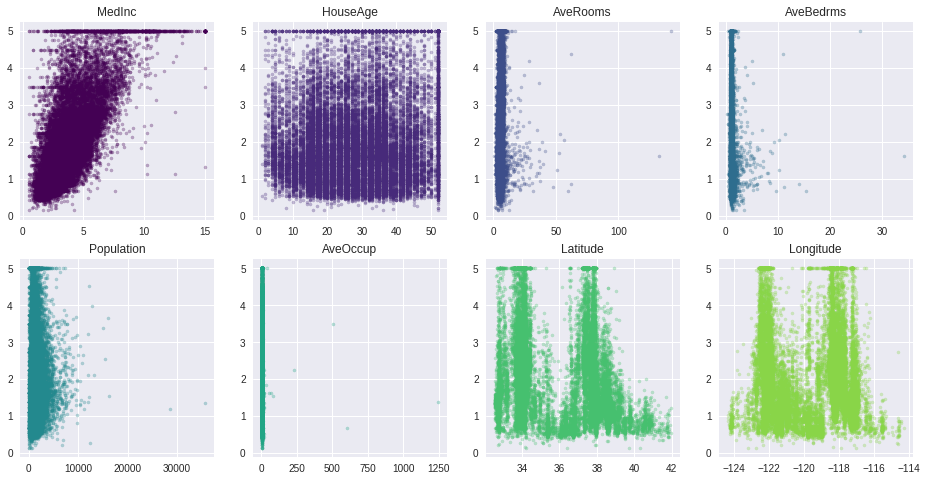

In [213]:
# plot preditor variables

def plotX(X):
    fig, ax = plt.subplots(2,4,figsize=(16,8))
    for i in range(8):
        i1 = (i>3)*1
        i2 = (i>3)+i*(i<=3)+(i-5)*(i>3)
        ax[i1,i2].scatter(X[:,i], y, 10, color=cm.viridis(i*30), alpha=.3)
        ax[i1,i2].set_title(housing.feature_names[i])

plotX(X)

In [214]:
# remove outliers

def reject_outliers(data, target, thresh=3.0):
    
    inds_good = np.arange(np.shape(data)[0])
    
    for feat in range(np.shape(data)[1]):
        u = np.mean(data[:,feat])
        s = np.std(data[:,feat])
        inds = (data[:,feat]>(u-thresh*s)) & (data[:,feat]<(u+thresh*s))
        inds = np.array(np.where(inds)).T
        inds_good = np.intersect1d(inds_good, inds)
        
    data_cleaned = data[inds_good, :]
    target_cleaned = target[inds_good]
    return data_cleaned, target_cleaned

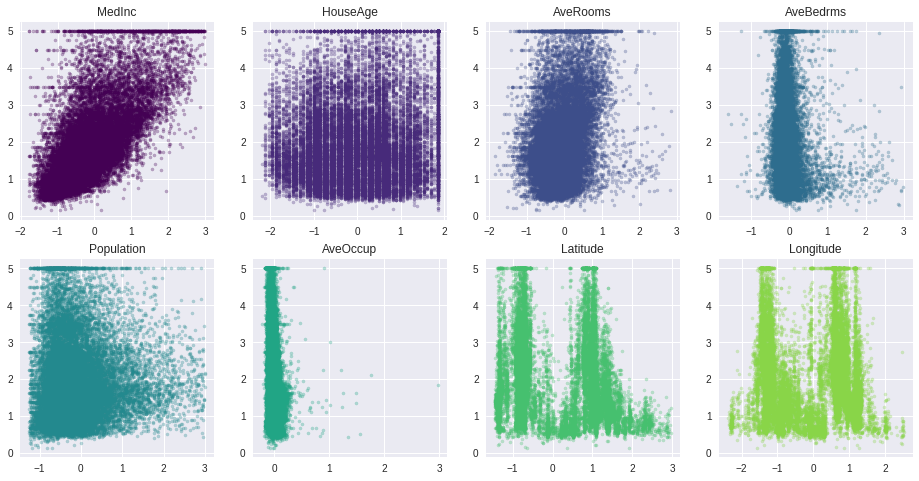

In [215]:
# plot with outliers removed

X, y = housing.data, housing.target
X = StandardScaler().fit_transform(X)
X, y = reject_outliers(X, y, 3.0)

plotX(X)

In [216]:
# prepare data for cross-validation

X, y = housing.data, housing.target
X = StandardScaler().fit_transform(X)
X, y = reject_outliers(X, y, 3.0)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.9)


/home/amandae/anaconda3/envs/nibeta/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [217]:
# pipeline + GridSearchCV

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

# define pipeline and parameter grid
def linreg_pipe(degree=1):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression())
    
param_grid = dict(polynomialfeatures__degree=np.arange(1,5))

# run grid search
lm = GridSearchCV(linreg_pipe(), param_grid=param_grid, scoring=['neg_mean_squared_error'], refit ='neg_mean_squared_error',
                    cv=10, n_jobs=1, verbose=0)

lm.fit(Xtrain, ytrain)

print('Best score: ', lm.best_score_, '\n')
print('Best parameters: ', lm.best_params_, '\n')
print('Best estimator: ', lm.best_estimator_)

Best score:  -0.38335798354225725 

Best parameters:  {'polynomialfeatures__degree': 2} 

Best estimator:  Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])


/home/amandae/anaconda3/envs/nibeta/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Rsquared =  0.7182225593330225
Mean squared error =  0.33475826001561454
# of model coefficients:  45
Model intercept:  1.8541239172516664


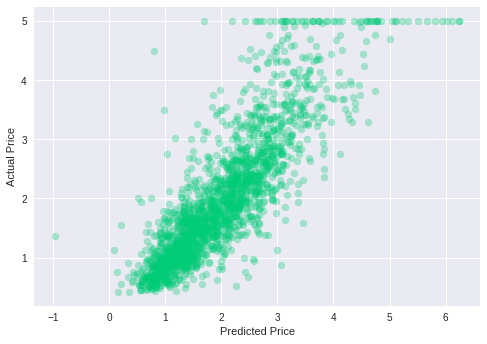

In [218]:
# evaluate model on test set 

from sklearn.metrics import explained_variance_score

ypred = lm.predict(Xtest)
print('Rsquared = ', explained_variance_score(ytest, ypred))
print('Mean squared error = ', -lm.score(Xtest,ytest)) #Rsquared
print('# of model coefficients: ', lm.best_estimator_.named_steps['linearregression'].coef_.shape[0])
print('Model intercept: ', lm.best_estimator_.named_steps['linearregression'].intercept_)
plt.scatter(ypred, ytest,  color='#00cc77', alpha=0.3)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price');